<a href="https://colab.research.google.com/github/SRDdev/SuperRes-GANs/blob/master/SuperresGANS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras import layers, Model
from sklearn.model_selection import train_test_split

import numpy as np
from keras import Model
from keras.layers import Conv2D, PReLU,BatchNormalization, Flatten
from keras.layers import UpSampling2D, LeakyReLU, Dense, Input, add
from tqdm import tqdm

## Define Blocks

In [2]:
#Define blocks to build the generator
def res_block(ip):
    
    res_model = Conv2D(64, (3,3), padding = "same")(ip)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    res_model = PReLU(shared_axes = [1,2])(res_model)
    
    res_model = Conv2D(64, (3,3), padding = "same")(res_model)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    
    return add([ip,res_model])

def upscale_block(ip):
    
    up_model = Conv2D(256, (3,3), padding="same")(ip)
    up_model = UpSampling2D( size = 2 )(up_model)
    up_model = PReLU(shared_axes=[1,2])(up_model)
    
    return up_model

#Generator model
def create_gen(gen_ip, num_res_block):
    layers = Conv2D(64, (9,9), padding="same")(gen_ip)
    layers = PReLU(shared_axes=[1,2])(layers)

    temp = layers

    for i in range(num_res_block):
        layers = res_block(layers)

    layers = Conv2D(64, (3,3), padding="same")(layers)
    layers = BatchNormalization(momentum=0.5)(layers)
    layers = add([layers,temp])

    layers = upscale_block(layers)
    layers = upscale_block(layers)

    op = Conv2D(3, (9,9), padding="same")(layers)

    return Model(inputs=gen_ip, outputs=op)

#Descriminator block that will be used to construct the discriminator
def discriminator_block(ip, filters, strides=1, bn=True):
    
    disc_model = Conv2D(filters, (3,3), strides = strides, padding="same")(ip)
    
    if bn:
        disc_model = BatchNormalization( momentum=0.8 )(disc_model)
    
    disc_model = LeakyReLU( alpha=0.2 )(disc_model)
    
    return disc_model


#Descriminartor, as described in the original paper
def create_disc(disc_ip):

    df = 64
    
    d1 = discriminator_block(disc_ip, df, bn=False)
    d2 = discriminator_block(d1, df, strides=2)
    d3 = discriminator_block(d2, df*2)
    d4 = discriminator_block(d3, df*2, strides=2)
    d5 = discriminator_block(d4, df*4)
    d6 = discriminator_block(d5, df*4, strides=2)
    d7 = discriminator_block(d6, df*8)
    d8 = discriminator_block(d7, df*8, strides=2)
    
    d8_5 = Flatten()(d8)
    d9 = Dense(df*16)(d8_5)
    d10 = LeakyReLU(alpha=0.2)(d9)
    validity = Dense(1, activation='sigmoid')(d10)

    return Model(disc_ip, validity)

VGG19 

We need VGG19 for the feature map obtained by the j-th convolution (after activation) before the i-th maxpooling layer within the VGG19 network.(as described in the paper)

Let us pick the 3rd block, last conv layer. 

Build a pre-trained VGG19 model that outputs image features extracted at the
 third block of the model

 VGG architecture: https://github.com/keras-team/keras/blob/master/keras/applications/vgg19.py

In [3]:
from keras.applications import VGG19

def build_vgg(hr_shape):
    
    vgg = VGG19(weights="imagenet",include_top=False, input_shape=hr_shape)
    
    return Model(inputs=vgg.inputs, outputs=vgg.layers[10].output)

#Combined model
def create_comb(gen_model, disc_model, vgg, lr_ip, hr_ip):
    gen_img = gen_model(lr_ip)
    
    gen_features = vgg(gen_img)
    
    disc_model.trainable = False
    validity = disc_model(gen_img)
    
    return Model(inputs=[lr_ip, hr_ip], outputs=[validity, gen_features])

In [4]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"srddev","key":"20845594c4df168ec8eb07e25bd60fa2"}'}

In [5]:
! pip install kaggle
! mkdir ~/.kaggle
! mv kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
! kaggle datasets download -d akhileshdkapse/super-image-resolution

 63% 17.0M/27.2M [00:00<00:00, 28.8MB/s]
100% 27.2M/27.2M [00:00<00:00, 45.6MB/s]


In [9]:
from zipfile import ZipFile as unzip
for _ , _  , filenames in os.walk('.'):
  for filename in filenames:
    if filename[-3:]=='zip':
      file = unzip(filename,'r')
      file.extractall()
      file.close()
      os.remove(filename)

In [68]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

train_dir = "/content/Data" 

for img in os.listdir( train_dir + "/HR"):
    img_array = cv2.imread(train_dir + "/HR/" + img)
    
    img_array = cv2.resize(img_array, (384,384))
    lr_img_array = cv2.resize(img_array,(96,96))
    cv2.imwrite(train_dir+ "/hr_images/" + img, img_array)
    cv2.imwrite(train_dir+ "/lr_images/"+ img, lr_img_array)

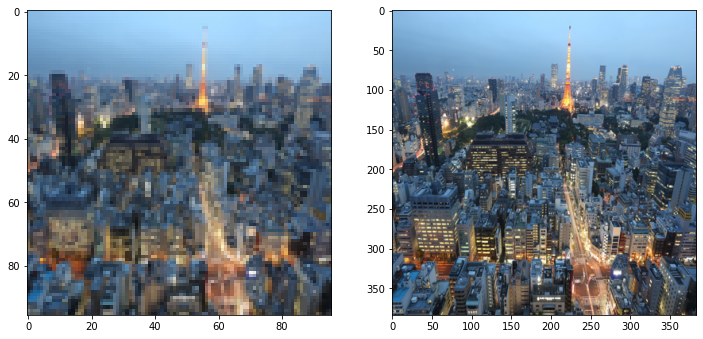

Model: "model_24"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_19 (InputLayer)          [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 conv2d_270 (Conv2D)            (None, 96, 96, 64)   15616       ['input_19[0][0]']               
                                                                                                  
 p_re_lu_114 (PReLU)            (None, 96, 96, 64)   64          ['conv2d_270[0][0]']             
                                                                                                  
 conv2d_271 (Conv2D)            (None, 96, 96, 64)   36928       ['p_re_lu_114[0][0]']            
                                                                                           

In [76]:
#Load first n number of images (to train on a subset of all images)
#For demo purposes, let us use 5000 images
n=10000
lr_list = os.listdir("/content/Data/LR")[:n]

lr_images = []
for img in lr_list:
    img_lr = cv2.imread("/content/Data/LR/" + img)
    img_lr = cv2.cvtColor(img_lr, cv2.COLOR_BGR2RGB)
    lr_images.append(img_lr)   


hr_list = os.listdir("/content/Data/HR")[:n]
   
hr_images = []
for img in hr_list:
    img_hr = cv2.imread("/content/Data/HR/" + img)
    img_hr = cv2.cvtColor(img_hr, cv2.COLOR_BGR2RGB)
    hr_images.append(img_hr)   

lr_images = np.array(lr_images)
hr_images = np.array(hr_images)

#Sanity check, view few mages
import random
import numpy as np
image_number = random.randint(0, len(lr_images)-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(lr_images[image_number], (96, 96, 3)))
plt.subplot(122)
plt.imshow(np.reshape(hr_images[image_number], (384, 384, 3)))
plt.show()

#Scale values
lr_images = lr_images / 255.
hr_images = hr_images / 255.

#Split to train and test
lr_train, lr_test, hr_train, hr_test = train_test_split(lr_images, hr_images, 
                                                      test_size=0.33, random_state=42)



hr_shape = (hr_train.shape[1], hr_train.shape[2], hr_train.shape[3])
lr_shape = (lr_train.shape[1], lr_train.shape[2], lr_train.shape[3])

lr_ip = Input(shape=lr_shape)
hr_ip = Input(shape=hr_shape)

generator = create_gen(lr_ip, num_res_block = 16)
generator.summary()

discriminator = create_disc(hr_ip)
discriminator.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
discriminator.summary()

vgg = build_vgg((384,384,3))
print(vgg.summary())
vgg.trainable = False

gan_model = create_comb(generator, discriminator, vgg, lr_ip, hr_ip)

In [77]:
gan_model.compile(loss=["binary_crossentropy", "mse"], loss_weights=[1e-3, 1], optimizer="adam")
gan_model.summary()

#Create a list of images for LR and HR in batches from which a batch of images
#would be fetched during training. 
batch_size = 1  
train_lr_batches = []
train_hr_batches = []
for it in range(int(hr_train.shape[0] / batch_size)):
    start_idx = it * batch_size
    end_idx = start_idx + batch_size
    train_hr_batches.append(hr_train[start_idx:end_idx])
    train_lr_batches.append(lr_train[start_idx:end_idx])
    
    
epochs = 5
#Enumerate training over epochs
for e in range(epochs):
    
    fake_label = np.zeros((batch_size, 1)) # Assign a label of 0 to all fake (generated images)
    real_label = np.ones((batch_size,1)) # Assign a label of 1 to all real images.
    
    #Create empty lists to populate gen and disc losses. 
    g_losses = []
    d_losses = []
    
    #Enumerate training over batches. 
    for b in tqdm(range(len(train_hr_batches))):
        lr_imgs = train_lr_batches[b] #Fetch a batch of LR images for training
        hr_imgs = train_hr_batches[b] #Fetch a batch of HR images for training
        
        fake_imgs = generator.predict_on_batch(lr_imgs) #Fake images
        
        #First, train the discriminator on fake and real HR images. 
        discriminator.trainable = True
        d_loss_gen = discriminator.train_on_batch(fake_imgs, fake_label)
        d_loss_real = discriminator.train_on_batch(hr_imgs, real_label)
        
        #Now, train the generator by fixing discriminator as non-trainable
        discriminator.trainable = False
        
        #Average the discriminator loss, just for reporting purposes. 
        d_loss = 0.25 * np.add(d_loss_gen, d_loss_real) 
        
        #Extract VGG features, to be used towards calculating loss
        image_features = vgg.predict(hr_imgs)
     
        #Train the generator via GAN. 
        #Remember that we have 2 losses, adversarial loss and content (VGG) loss
        g_loss, _, _ = gan_model.train_on_batch([lr_imgs, hr_imgs], [real_label, image_features])
        
        #Save losses to a list so we can average and report. 
        d_losses.append(d_loss)
        g_losses.append(g_loss)
        
    #Convert the list of losses to an array to make it easy to average    
    g_losses = np.array(g_losses)
    d_losses = np.array(d_losses)
    
    #Calculate the average losses for generator and discriminator
    g_loss = np.sum(g_losses, axis=0) / len(g_losses)
    d_loss = np.sum(d_losses, axis=0) / len(d_losses)
    
    #Report the progress during training. 
    print("epoch:", e+1 ,"g_loss:", g_loss, "d_loss:", d_loss)

    if (e+1) % 10 == 0: #Change the frequency for model saving, if needed
        #Save the generator after every n epochs (Usually 10 epochs)
        generator.save("gen_e_"+ str(e+1) +".h5")


Model: "model_27"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_19 (InputLayer)          [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 model_24 (Functional)          (None, 384, 384, 3)  2044291     ['input_19[0][0]']               
                                                                                                  
 input_20 (InputLayer)          [(None, 384, 384, 3  0           []                               
                                )]                                                                
                                                                                                  
 model_25 (Functional)          (None, 1)            306684737   ['model_24[0][0]']        

  0%|          | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 94ms/step


  1%|▏         | 1/67 [00:06<07:16,  6.62s/it]

1/1 [==============================] - 0s 16ms/step


  3%|▎         | 2/67 [00:07<03:22,  3.12s/it]

1/1 [==============================] - 0s 14ms/step


  4%|▍         | 3/67 [00:07<02:07,  2.00s/it]

1/1 [==============================] - 0s 17ms/step


  6%|▌         | 4/67 [00:08<01:32,  1.47s/it]

1/1 [==============================] - 0s 15ms/step


  7%|▋         | 5/67 [00:09<01:13,  1.18s/it]

1/1 [==============================] - 0s 16ms/step


  9%|▉         | 6/67 [00:09<01:01,  1.00s/it]

1/1 [==============================] - 0s 14ms/step


 10%|█         | 7/67 [00:10<00:53,  1.12it/s]

1/1 [==============================] - 0s 15ms/step


 12%|█▏        | 8/67 [00:11<00:53,  1.10it/s]

1/1 [==============================] - 0s 15ms/step


 13%|█▎        | 9/67 [00:12<00:47,  1.21it/s]

1/1 [==============================] - 0s 15ms/step


 15%|█▍        | 10/67 [00:12<00:44,  1.29it/s]

1/1 [==============================] - 0s 14ms/step


 16%|█▋        | 11/67 [00:13<00:41,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 12/67 [00:14<00:39,  1.40it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 13/67 [00:14<00:38,  1.40it/s]

1/1 [==============================] - 0s 14ms/step


 21%|██        | 14/67 [00:15<00:37,  1.43it/s]

1/1 [==============================] - 0s 14ms/step


 22%|██▏       | 15/67 [00:16<00:35,  1.45it/s]

1/1 [==============================] - 0s 23ms/step


 24%|██▍       | 16/67 [00:16<00:34,  1.47it/s]

1/1 [==============================] - 0s 14ms/step


 25%|██▌       | 17/67 [00:17<00:33,  1.47it/s]

1/1 [==============================] - 0s 14ms/step


 27%|██▋       | 18/67 [00:18<00:32,  1.49it/s]

1/1 [==============================] - 0s 15ms/step


 28%|██▊       | 19/67 [00:18<00:32,  1.49it/s]

1/1 [==============================] - 0s 23ms/step


 30%|██▉       | 20/67 [00:19<00:31,  1.49it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███▏      | 21/67 [00:20<00:30,  1.50it/s]

1/1 [==============================] - 0s 15ms/step


 33%|███▎      | 22/67 [00:20<00:29,  1.50it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 23/67 [00:21<00:29,  1.50it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 24/67 [00:22<00:28,  1.50it/s]

1/1 [==============================] - 0s 15ms/step


 37%|███▋      | 25/67 [00:22<00:28,  1.49it/s]

1/1 [==============================] - 0s 15ms/step


 39%|███▉      | 26/67 [00:23<00:27,  1.50it/s]

1/1 [==============================] - 0s 14ms/step


 40%|████      | 27/67 [00:24<00:26,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 28/67 [00:24<00:26,  1.50it/s]

1/1 [==============================] - 0s 15ms/step


 43%|████▎     | 29/67 [00:25<00:25,  1.50it/s]

1/1 [==============================] - 0s 15ms/step


 45%|████▍     | 30/67 [00:26<00:24,  1.50it/s]

1/1 [==============================] - 0s 14ms/step


 46%|████▋     | 31/67 [00:26<00:24,  1.50it/s]

1/1 [==============================] - 0s 14ms/step


 48%|████▊     | 32/67 [00:27<00:23,  1.50it/s]

1/1 [==============================] - 0s 14ms/step


 49%|████▉     | 33/67 [00:28<00:22,  1.50it/s]

1/1 [==============================] - 0s 14ms/step


 51%|█████     | 34/67 [00:28<00:22,  1.49it/s]

1/1 [==============================] - 0s 15ms/step


 52%|█████▏    | 35/67 [00:29<00:21,  1.49it/s]

1/1 [==============================] - 0s 16ms/step


 54%|█████▎    | 36/67 [00:30<00:20,  1.49it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 37/67 [00:30<00:20,  1.48it/s]

1/1 [==============================] - 0s 17ms/step


 57%|█████▋    | 38/67 [00:31<00:19,  1.49it/s]

1/1 [==============================] - 0s 14ms/step


 58%|█████▊    | 39/67 [00:32<00:18,  1.49it/s]

1/1 [==============================] - 0s 14ms/step


 60%|█████▉    | 40/67 [00:33<00:20,  1.32it/s]

1/1 [==============================] - 0s 17ms/step


 61%|██████    | 41/67 [00:33<00:19,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 42/67 [00:34<00:17,  1.40it/s]

1/1 [==============================] - 0s 15ms/step


 64%|██████▍   | 43/67 [00:35<00:16,  1.43it/s]

1/1 [==============================] - 0s 16ms/step


 66%|██████▌   | 44/67 [00:35<00:15,  1.44it/s]

1/1 [==============================] - 0s 15ms/step


 67%|██████▋   | 45/67 [00:36<00:15,  1.45it/s]

1/1 [==============================] - 0s 15ms/step


 69%|██████▊   | 46/67 [00:37<00:14,  1.46it/s]

1/1 [==============================] - 0s 14ms/step


 70%|███████   | 47/67 [00:37<00:13,  1.47it/s]

1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 48/67 [00:38<00:12,  1.48it/s]

1/1 [==============================] - 0s 14ms/step


 73%|███████▎  | 49/67 [00:39<00:12,  1.48it/s]

1/1 [==============================] - 0s 15ms/step


 75%|███████▍  | 50/67 [00:39<00:11,  1.49it/s]

1/1 [==============================] - 0s 14ms/step


 76%|███████▌  | 51/67 [00:40<00:10,  1.49it/s]

1/1 [==============================] - 0s 15ms/step


 78%|███████▊  | 52/67 [00:41<00:10,  1.49it/s]

1/1 [==============================] - 0s 14ms/step


 79%|███████▉  | 53/67 [00:41<00:09,  1.48it/s]

1/1 [==============================] - 0s 15ms/step


 81%|████████  | 54/67 [00:42<00:08,  1.48it/s]

1/1 [==============================] - 0s 15ms/step


 82%|████████▏ | 55/67 [00:43<00:08,  1.49it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▎ | 56/67 [00:43<00:07,  1.49it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▌ | 57/67 [00:44<00:06,  1.48it/s]

1/1 [==============================] - 0s 15ms/step


 87%|████████▋ | 58/67 [00:45<00:06,  1.33it/s]

1/1 [==============================] - 0s 14ms/step


 88%|████████▊ | 59/67 [00:46<00:05,  1.37it/s]

1/1 [==============================] - 0s 14ms/step


 90%|████████▉ | 60/67 [00:46<00:04,  1.40it/s]

1/1 [==============================] - 0s 14ms/step


 91%|█████████ | 61/67 [00:47<00:04,  1.43it/s]

1/1 [==============================] - 0s 15ms/step


 93%|█████████▎| 62/67 [00:48<00:03,  1.45it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▍| 63/67 [00:48<00:02,  1.46it/s]

1/1 [==============================] - 0s 15ms/step


 96%|█████████▌| 64/67 [00:49<00:02,  1.48it/s]

1/1 [==============================] - 0s 15ms/step


 97%|█████████▋| 65/67 [00:50<00:01,  1.48it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▊| 66/67 [00:50<00:00,  1.48it/s]

1/1 [==============================] - 0s 16ms/step


100%|██████████| 67/67 [00:51<00:00,  1.30it/s]


epoch: 1 g_loss: 122.05983739824437 d_loss: [31.39344758  0.30970149]


  0%|          | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step


  1%|▏         | 1/67 [00:00<00:43,  1.50it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 2/67 [00:01<00:43,  1.50it/s]

1/1 [==============================] - 0s 15ms/step


  4%|▍         | 3/67 [00:01<00:42,  1.50it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▌         | 4/67 [00:02<00:41,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


  7%|▋         | 5/67 [00:03<00:41,  1.50it/s]

1/1 [==============================] - 0s 15ms/step


  9%|▉         | 6/67 [00:03<00:40,  1.50it/s]

1/1 [==============================] - 0s 15ms/step


 10%|█         | 7/67 [00:04<00:40,  1.47it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 8/67 [00:05<00:39,  1.48it/s]

1/1 [==============================] - 0s 14ms/step


 13%|█▎        | 9/67 [00:06<00:39,  1.48it/s]

1/1 [==============================] - 0s 15ms/step


 15%|█▍        | 10/67 [00:06<00:38,  1.49it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▋        | 11/67 [00:07<00:37,  1.49it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 12/67 [00:08<00:36,  1.50it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▉        | 13/67 [00:09<00:42,  1.28it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██        | 14/67 [00:09<00:42,  1.24it/s]

1/1 [==============================] - 0s 15ms/step


 22%|██▏       | 15/67 [00:10<00:39,  1.30it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 16/67 [00:11<00:37,  1.36it/s]

1/1 [==============================] - 0s 15ms/step


 25%|██▌       | 17/67 [00:11<00:35,  1.40it/s]

1/1 [==============================] - 0s 15ms/step


 27%|██▋       | 18/67 [00:12<00:34,  1.43it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 19/67 [00:13<00:33,  1.45it/s]

1/1 [==============================] - 0s 14ms/step


 30%|██▉       | 20/67 [00:13<00:31,  1.47it/s]

1/1 [==============================] - 0s 15ms/step


 31%|███▏      | 21/67 [00:14<00:31,  1.48it/s]

1/1 [==============================] - 0s 15ms/step


 33%|███▎      | 22/67 [00:15<00:30,  1.48it/s]

1/1 [==============================] - 0s 14ms/step


 34%|███▍      | 23/67 [00:15<00:29,  1.49it/s]

1/1 [==============================] - 0s 15ms/step


 36%|███▌      | 24/67 [00:16<00:28,  1.50it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 25/67 [00:17<00:28,  1.50it/s]

1/1 [==============================] - 0s 15ms/step


 39%|███▉      | 26/67 [00:17<00:27,  1.51it/s]

1/1 [==============================] - 0s 14ms/step


 40%|████      | 27/67 [00:18<00:26,  1.51it/s]

1/1 [==============================] - 0s 15ms/step


 42%|████▏     | 28/67 [00:19<00:25,  1.52it/s]

1/1 [==============================] - 0s 14ms/step


 43%|████▎     | 29/67 [00:19<00:25,  1.52it/s]

1/1 [==============================] - 0s 15ms/step


 45%|████▍     | 30/67 [00:20<00:24,  1.51it/s]

1/1 [==============================] - 0s 14ms/step


 46%|████▋     | 31/67 [00:21<00:23,  1.51it/s]

1/1 [==============================] - 0s 15ms/step


 48%|████▊     | 32/67 [00:21<00:23,  1.51it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 33/67 [00:22<00:23,  1.47it/s]

1/1 [==============================] - 0s 15ms/step


 51%|█████     | 34/67 [00:23<00:22,  1.48it/s]

1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 35/67 [00:23<00:21,  1.49it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▎    | 36/67 [00:24<00:20,  1.49it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 37/67 [00:25<00:20,  1.49it/s]

1/1 [==============================] - 0s 17ms/step


 57%|█████▋    | 38/67 [00:25<00:19,  1.49it/s]

1/1 [==============================] - 0s 15ms/step


 58%|█████▊    | 39/67 [00:26<00:18,  1.50it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 40/67 [00:27<00:18,  1.49it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████    | 41/67 [00:27<00:17,  1.49it/s]

1/1 [==============================] - 0s 15ms/step


 63%|██████▎   | 42/67 [00:28<00:16,  1.49it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 43/67 [00:29<00:16,  1.49it/s]

1/1 [==============================] - 0s 15ms/step


 66%|██████▌   | 44/67 [00:29<00:15,  1.50it/s]

1/1 [==============================] - 0s 15ms/step


 67%|██████▋   | 45/67 [00:30<00:14,  1.50it/s]

1/1 [==============================] - 0s 15ms/step


 69%|██████▊   | 46/67 [00:31<00:13,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 70%|███████   | 47/67 [00:31<00:13,  1.50it/s]

1/1 [==============================] - 0s 14ms/step


 72%|███████▏  | 48/67 [00:32<00:12,  1.50it/s]

1/1 [==============================] - 0s 15ms/step


 73%|███████▎  | 49/67 [00:33<00:12,  1.48it/s]

1/1 [==============================] - 0s 14ms/step


 75%|███████▍  | 50/67 [00:33<00:11,  1.49it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 51/67 [00:34<00:10,  1.49it/s]

1/1 [==============================] - 0s 15ms/step


 78%|███████▊  | 52/67 [00:35<00:10,  1.49it/s]

1/1 [==============================] - 0s 14ms/step


 79%|███████▉  | 53/67 [00:36<00:10,  1.33it/s]

1/1 [==============================] - 0s 23ms/step


 81%|████████  | 54/67 [00:37<00:10,  1.30it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 55/67 [00:37<00:08,  1.35it/s]

1/1 [==============================] - 0s 15ms/step


 84%|████████▎ | 56/67 [00:38<00:07,  1.40it/s]

1/1 [==============================] - 0s 16ms/step


 85%|████████▌ | 57/67 [00:39<00:07,  1.43it/s]

1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 58/67 [00:39<00:06,  1.45it/s]

1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 59/67 [00:40<00:05,  1.46it/s]

1/1 [==============================] - 0s 15ms/step


 90%|████████▉ | 60/67 [00:41<00:04,  1.47it/s]

1/1 [==============================] - 0s 14ms/step


 91%|█████████ | 61/67 [00:41<00:04,  1.48it/s]

1/1 [==============================] - 0s 16ms/step


 93%|█████████▎| 62/67 [00:42<00:03,  1.48it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▍| 63/67 [00:43<00:02,  1.49it/s]

1/1 [==============================] - 0s 15ms/step


 96%|█████████▌| 64/67 [00:43<00:02,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████▋| 65/67 [00:44<00:01,  1.50it/s]

1/1 [==============================] - 0s 14ms/step


 99%|█████████▊| 66/67 [00:45<00:00,  1.50it/s]

1/1 [==============================] - 0s 15ms/step


100%|██████████| 67/67 [00:45<00:00,  1.47it/s]


epoch: 2 g_loss: 89.9662602837406 d_loss: [12.01025855  0.29104478]


  0%|          | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  1%|▏         | 1/67 [00:00<00:43,  1.51it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 2/67 [00:01<00:43,  1.50it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 3/67 [00:02<00:42,  1.50it/s]

1/1 [==============================] - 0s 15ms/step


  6%|▌         | 4/67 [00:02<00:42,  1.49it/s]

1/1 [==============================] - 0s 15ms/step


  7%|▋         | 5/67 [00:03<00:41,  1.49it/s]

1/1 [==============================] - 0s 15ms/step


  9%|▉         | 6/67 [00:04<00:41,  1.49it/s]

1/1 [==============================] - 0s 15ms/step


 10%|█         | 7/67 [00:04<00:40,  1.49it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 8/67 [00:05<00:40,  1.46it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 9/67 [00:06<00:39,  1.47it/s]

1/1 [==============================] - 0s 15ms/step


 15%|█▍        | 10/67 [00:06<00:38,  1.48it/s]

1/1 [==============================] - 0s 15ms/step


 16%|█▋        | 11/67 [00:07<00:37,  1.49it/s]

1/1 [==============================] - 0s 15ms/step


 18%|█▊        | 12/67 [00:08<00:36,  1.49it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 13/67 [00:08<00:36,  1.49it/s]

1/1 [==============================] - 0s 14ms/step


 21%|██        | 14/67 [00:09<00:36,  1.46it/s]

1/1 [==============================] - 0s 14ms/step


 22%|██▏       | 15/67 [00:10<00:35,  1.47it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▍       | 16/67 [00:10<00:34,  1.48it/s]

1/1 [==============================] - 0s 15ms/step


 25%|██▌       | 17/67 [00:11<00:33,  1.48it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 18/67 [00:12<00:33,  1.47it/s]

1/1 [==============================] - 0s 30ms/step


 28%|██▊       | 19/67 [00:12<00:33,  1.44it/s]

1/1 [==============================] - 0s 15ms/step


 30%|██▉       | 20/67 [00:13<00:32,  1.46it/s]

1/1 [==============================] - 0s 16ms/step


 31%|███▏      | 21/67 [00:14<00:31,  1.44it/s]

1/1 [==============================] - 0s 15ms/step


 33%|███▎      | 22/67 [00:14<00:30,  1.46it/s]

1/1 [==============================] - 0s 15ms/step


 34%|███▍      | 23/67 [00:15<00:29,  1.47it/s]

1/1 [==============================] - 0s 15ms/step


 36%|███▌      | 24/67 [00:16<00:29,  1.48it/s]

1/1 [==============================] - 0s 15ms/step


 37%|███▋      | 25/67 [00:16<00:28,  1.48it/s]

1/1 [==============================] - 0s 17ms/step


 39%|███▉      | 26/67 [00:17<00:27,  1.48it/s]

1/1 [==============================] - 0s 17ms/step


 40%|████      | 27/67 [00:18<00:26,  1.48it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 28/67 [00:18<00:26,  1.49it/s]

1/1 [==============================] - 0s 16ms/step


 43%|████▎     | 29/67 [00:19<00:25,  1.49it/s]

1/1 [==============================] - 0s 15ms/step


 45%|████▍     | 30/67 [00:20<00:24,  1.50it/s]

1/1 [==============================] - 0s 15ms/step


 46%|████▋     | 31/67 [00:20<00:24,  1.50it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 32/67 [00:21<00:23,  1.50it/s]

1/1 [==============================] - 0s 14ms/step


 49%|████▉     | 33/67 [00:22<00:22,  1.50it/s]

1/1 [==============================] - 0s 14ms/step


 51%|█████     | 34/67 [00:22<00:22,  1.49it/s]

1/1 [==============================] - 0s 15ms/step


 52%|█████▏    | 35/67 [00:23<00:21,  1.49it/s]

1/1 [==============================] - 0s 15ms/step


 54%|█████▎    | 36/67 [00:24<00:20,  1.49it/s]

1/1 [==============================] - 0s 15ms/step


 55%|█████▌    | 37/67 [00:24<00:20,  1.49it/s]

1/1 [==============================] - 0s 17ms/step


 57%|█████▋    | 38/67 [00:25<00:19,  1.49it/s]

1/1 [==============================] - 0s 15ms/step


 58%|█████▊    | 39/67 [00:26<00:18,  1.49it/s]

1/1 [==============================] - 0s 19ms/step


 60%|█████▉    | 40/67 [00:26<00:18,  1.49it/s]

1/1 [==============================] - 0s 15ms/step


 61%|██████    | 41/67 [00:27<00:17,  1.49it/s]

1/1 [==============================] - 0s 14ms/step


 63%|██████▎   | 42/67 [00:28<00:16,  1.50it/s]

1/1 [==============================] - 0s 15ms/step


 64%|██████▍   | 43/67 [00:28<00:16,  1.49it/s]

1/1 [==============================] - 0s 15ms/step


 66%|██████▌   | 44/67 [00:29<00:15,  1.49it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 45/67 [00:30<00:14,  1.49it/s]

1/1 [==============================] - 0s 15ms/step


 69%|██████▊   | 46/67 [00:31<00:14,  1.49it/s]

1/1 [==============================] - 0s 17ms/step


 70%|███████   | 47/67 [00:31<00:15,  1.32it/s]

1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 48/67 [00:32<00:13,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 73%|███████▎  | 49/67 [00:33<00:12,  1.41it/s]

1/1 [==============================] - 0s 16ms/step


 75%|███████▍  | 50/67 [00:33<00:11,  1.43it/s]

1/1 [==============================] - 0s 15ms/step


 76%|███████▌  | 51/67 [00:34<00:11,  1.44it/s]

1/1 [==============================] - 0s 15ms/step


 78%|███████▊  | 52/67 [00:35<00:10,  1.46it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 53/67 [00:35<00:09,  1.47it/s]

1/1 [==============================] - 0s 15ms/step


 81%|████████  | 54/67 [00:36<00:08,  1.47it/s]

1/1 [==============================] - 0s 15ms/step


 82%|████████▏ | 55/67 [00:37<00:08,  1.48it/s]

1/1 [==============================] - 0s 16ms/step


 84%|████████▎ | 56/67 [00:38<00:07,  1.48it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▌ | 57/67 [00:38<00:06,  1.49it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 58/67 [00:39<00:06,  1.46it/s]

1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 59/67 [00:40<00:05,  1.47it/s]

1/1 [==============================] - 0s 17ms/step


 90%|████████▉ | 60/67 [00:40<00:04,  1.48it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 61/67 [00:41<00:04,  1.49it/s]

1/1 [==============================] - 0s 15ms/step


 93%|█████████▎| 62/67 [00:42<00:03,  1.49it/s]

1/1 [==============================] - 0s 14ms/step


 94%|█████████▍| 63/67 [00:42<00:02,  1.49it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 64/67 [00:43<00:02,  1.49it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████▋| 65/67 [00:44<00:01,  1.49it/s]

1/1 [==============================] - 0s 15ms/step


 99%|█████████▊| 66/67 [00:44<00:00,  1.49it/s]

1/1 [==============================] - 0s 15ms/step


100%|██████████| 67/67 [00:45<00:00,  1.48it/s]


epoch: 3 g_loss: 72.15586685066792 d_loss: [4.70792326 0.36567164]


  0%|          | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 14ms/step


  1%|▏         | 1/67 [00:00<00:43,  1.51it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 2/67 [00:01<00:43,  1.51it/s]

1/1 [==============================] - 0s 15ms/step


  4%|▍         | 3/67 [00:01<00:42,  1.50it/s]

1/1 [==============================] - 0s 15ms/step


  6%|▌         | 4/67 [00:02<00:41,  1.51it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 5/67 [00:03<00:41,  1.50it/s]

1/1 [==============================] - 0s 15ms/step


  9%|▉         | 6/67 [00:03<00:40,  1.50it/s]

1/1 [==============================] - 0s 15ms/step


 10%|█         | 7/67 [00:04<00:40,  1.50it/s]

1/1 [==============================] - 0s 15ms/step


 12%|█▏        | 8/67 [00:05<00:39,  1.50it/s]

1/1 [==============================] - 0s 15ms/step


 13%|█▎        | 9/67 [00:06<00:39,  1.47it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▍        | 10/67 [00:06<00:38,  1.47it/s]

1/1 [==============================] - 0s 14ms/step


 16%|█▋        | 11/67 [00:07<00:37,  1.48it/s]

1/1 [==============================] - 0s 15ms/step


 18%|█▊        | 12/67 [00:08<00:37,  1.48it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 13/67 [00:08<00:36,  1.49it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 14/67 [00:09<00:35,  1.49it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 15/67 [00:10<00:34,  1.49it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 16/67 [00:10<00:34,  1.49it/s]

1/1 [==============================] - 0s 15ms/step


 25%|██▌       | 17/67 [00:11<00:33,  1.50it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 18/67 [00:12<00:33,  1.46it/s]

1/1 [==============================] - 0s 14ms/step


 28%|██▊       | 19/67 [00:12<00:32,  1.47it/s]

1/1 [==============================] - 0s 15ms/step


 30%|██▉       | 20/67 [00:13<00:31,  1.48it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███▏      | 21/67 [00:14<00:31,  1.48it/s]

1/1 [==============================] - 0s 15ms/step


 33%|███▎      | 22/67 [00:14<00:30,  1.49it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 23/67 [00:15<00:29,  1.49it/s]

1/1 [==============================] - 0s 14ms/step


 36%|███▌      | 24/67 [00:16<00:28,  1.49it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 25/67 [00:16<00:27,  1.50it/s]

1/1 [==============================] - 0s 14ms/step


 39%|███▉      | 26/67 [00:17<00:27,  1.50it/s]

1/1 [==============================] - 0s 15ms/step


 40%|████      | 27/67 [00:18<00:26,  1.50it/s]

1/1 [==============================] - 0s 15ms/step


 42%|████▏     | 28/67 [00:18<00:26,  1.50it/s]

1/1 [==============================] - 0s 15ms/step


 43%|████▎     | 29/67 [00:19<00:25,  1.49it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 30/67 [00:20<00:24,  1.50it/s]

1/1 [==============================] - 0s 14ms/step


 46%|████▋     | 31/67 [00:20<00:24,  1.46it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 32/67 [00:21<00:23,  1.47it/s]

1/1 [==============================] - 0s 16ms/step


 49%|████▉     | 33/67 [00:22<00:23,  1.46it/s]

1/1 [==============================] - 0s 14ms/step


 51%|█████     | 34/67 [00:22<00:22,  1.48it/s]

1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 35/67 [00:23<00:21,  1.48it/s]

1/1 [==============================] - 0s 15ms/step


 54%|█████▎    | 36/67 [00:24<00:20,  1.48it/s]

1/1 [==============================] - 0s 14ms/step


 55%|█████▌    | 37/67 [00:24<00:20,  1.49it/s]

1/1 [==============================] - 0s 15ms/step


 57%|█████▋    | 38/67 [00:25<00:19,  1.49it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 39/67 [00:26<00:18,  1.49it/s]

1/1 [==============================] - 0s 15ms/step


 60%|█████▉    | 40/67 [00:26<00:18,  1.49it/s]

1/1 [==============================] - 0s 17ms/step


 61%|██████    | 41/67 [00:27<00:17,  1.47it/s]

1/1 [==============================] - 0s 16ms/step


 63%|██████▎   | 42/67 [00:28<00:16,  1.47it/s]

1/1 [==============================] - 0s 14ms/step


 64%|██████▍   | 43/67 [00:28<00:16,  1.48it/s]

1/1 [==============================] - 0s 16ms/step


 66%|██████▌   | 44/67 [00:29<00:15,  1.49it/s]

1/1 [==============================] - 0s 15ms/step


 67%|██████▋   | 45/67 [00:30<00:14,  1.49it/s]

1/1 [==============================] - 0s 15ms/step


 69%|██████▊   | 46/67 [00:30<00:14,  1.48it/s]

1/1 [==============================] - 0s 15ms/step


 70%|███████   | 47/67 [00:31<00:13,  1.49it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 48/67 [00:32<00:12,  1.49it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 49/67 [00:32<00:12,  1.49it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▍  | 50/67 [00:33<00:11,  1.49it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 51/67 [00:34<00:10,  1.49it/s]

1/1 [==============================] - 0s 14ms/step


 78%|███████▊  | 52/67 [00:34<00:10,  1.50it/s]

1/1 [==============================] - 0s 15ms/step


 79%|███████▉  | 53/67 [00:35<00:09,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 81%|████████  | 54/67 [00:36<00:08,  1.49it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 55/67 [00:36<00:08,  1.49it/s]

1/1 [==============================] - 0s 15ms/step


 84%|████████▎ | 56/67 [00:37<00:07,  1.49it/s]

1/1 [==============================] - 0s 15ms/step


 85%|████████▌ | 57/67 [00:38<00:06,  1.49it/s]

1/1 [==============================] - 0s 15ms/step


 87%|████████▋ | 58/67 [00:38<00:06,  1.49it/s]

1/1 [==============================] - 0s 15ms/step


 88%|████████▊ | 59/67 [00:39<00:05,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 90%|████████▉ | 60/67 [00:40<00:04,  1.49it/s]

1/1 [==============================] - 0s 15ms/step


 91%|█████████ | 61/67 [00:40<00:04,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 93%|█████████▎| 62/67 [00:41<00:03,  1.46it/s]

1/1 [==============================] - 0s 15ms/step


 94%|█████████▍| 63/67 [00:42<00:02,  1.47it/s]

1/1 [==============================] - 0s 15ms/step


 96%|█████████▌| 64/67 [00:43<00:02,  1.48it/s]

1/1 [==============================] - 0s 15ms/step


 97%|█████████▋| 65/67 [00:43<00:01,  1.49it/s]

1/1 [==============================] - 0s 15ms/step


 99%|█████████▊| 66/67 [00:44<00:00,  1.49it/s]

1/1 [==============================] - 0s 16ms/step


100%|██████████| 67/67 [00:45<00:00,  1.49it/s]


epoch: 4 g_loss: 63.09626906665403 d_loss: [2.84333892 0.37313433]


  0%|          | 0/67 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step


  1%|▏         | 1/67 [00:00<00:43,  1.51it/s]

1/1 [==============================] - 0s 15ms/step


  3%|▎         | 2/67 [00:01<00:45,  1.44it/s]

1/1 [==============================] - 0s 15ms/step


  4%|▍         | 3/67 [00:02<00:43,  1.46it/s]

1/1 [==============================] - 0s 15ms/step


  6%|▌         | 4/67 [00:02<00:42,  1.47it/s]

1/1 [==============================] - 0s 14ms/step


  7%|▋         | 5/67 [00:03<00:41,  1.48it/s]

1/1 [==============================] - 0s 16ms/step


  9%|▉         | 6/67 [00:04<00:41,  1.49it/s]

1/1 [==============================] - 0s 15ms/step


 10%|█         | 7/67 [00:04<00:40,  1.49it/s]

1/1 [==============================] - 0s 15ms/step


 12%|█▏        | 8/67 [00:05<00:39,  1.49it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 9/67 [00:06<00:38,  1.49it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▍        | 10/67 [00:06<00:38,  1.49it/s]

1/1 [==============================] - 0s 15ms/step


 16%|█▋        | 11/67 [00:07<00:37,  1.49it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 12/67 [00:08<00:36,  1.50it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 13/67 [00:08<00:36,  1.49it/s]

1/1 [==============================] - 0s 15ms/step


 21%|██        | 14/67 [00:09<00:35,  1.49it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 15/67 [00:10<00:34,  1.49it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 16/67 [00:10<00:34,  1.49it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▌       | 17/67 [00:11<00:33,  1.49it/s]

1/1 [==============================] - 0s 14ms/step


 27%|██▋       | 18/67 [00:12<00:32,  1.49it/s]

1/1 [==============================] - 0s 15ms/step


 28%|██▊       | 19/67 [00:12<00:32,  1.47it/s]

1/1 [==============================] - 0s 18ms/step


 30%|██▉       | 20/67 [00:13<00:31,  1.48it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███▏      | 21/67 [00:14<00:30,  1.49it/s]

1/1 [==============================] - 0s 15ms/step


 33%|███▎      | 22/67 [00:14<00:30,  1.49it/s]

1/1 [==============================] - 0s 15ms/step


 34%|███▍      | 23/67 [00:15<00:29,  1.49it/s]

1/1 [==============================] - 0s 15ms/step


 36%|███▌      | 24/67 [00:16<00:28,  1.49it/s]

1/1 [==============================] - 0s 14ms/step


 37%|███▋      | 25/67 [00:16<00:28,  1.49it/s]

1/1 [==============================] - 0s 15ms/step


 39%|███▉      | 26/67 [00:17<00:30,  1.33it/s]

1/1 [==============================] - 0s 14ms/step


 40%|████      | 27/67 [00:18<00:29,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 28/67 [00:19<00:27,  1.41it/s]

1/1 [==============================] - 0s 14ms/step


 43%|████▎     | 29/67 [00:19<00:26,  1.43it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▍     | 30/67 [00:20<00:25,  1.45it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▋     | 31/67 [00:21<00:24,  1.46it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 32/67 [00:21<00:23,  1.47it/s]

1/1 [==============================] - 0s 15ms/step


 49%|████▉     | 33/67 [00:22<00:22,  1.48it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████     | 34/67 [00:23<00:22,  1.49it/s]

1/1 [==============================] - 0s 15ms/step


 52%|█████▏    | 35/67 [00:23<00:21,  1.49it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▎    | 36/67 [00:24<00:20,  1.49it/s]

1/1 [==============================] - 0s 15ms/step


 55%|█████▌    | 37/67 [00:25<00:20,  1.48it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 38/67 [00:25<00:19,  1.48it/s]

1/1 [==============================] - 0s 14ms/step


 58%|█████▊    | 39/67 [00:26<00:18,  1.49it/s]

1/1 [==============================] - 0s 15ms/step


 60%|█████▉    | 40/67 [00:27<00:18,  1.49it/s]

1/1 [==============================] - 0s 15ms/step


 61%|██████    | 41/67 [00:27<00:17,  1.49it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 42/67 [00:28<00:16,  1.49it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 43/67 [00:29<00:16,  1.49it/s]

1/1 [==============================] - 0s 15ms/step


 66%|██████▌   | 44/67 [00:29<00:15,  1.49it/s]

1/1 [==============================] - 0s 15ms/step


 67%|██████▋   | 45/67 [00:30<00:14,  1.49it/s]

1/1 [==============================] - 0s 15ms/step


 69%|██████▊   | 46/67 [00:31<00:14,  1.49it/s]

1/1 [==============================] - 0s 15ms/step


 70%|███████   | 47/67 [00:31<00:13,  1.49it/s]

1/1 [==============================] - 0s 15ms/step


 72%|███████▏  | 48/67 [00:32<00:12,  1.49it/s]

1/1 [==============================] - 0s 15ms/step


 73%|███████▎  | 49/67 [00:33<00:12,  1.49it/s]

1/1 [==============================] - 0s 17ms/step


 75%|███████▍  | 50/67 [00:33<00:11,  1.48it/s]

1/1 [==============================] - 0s 15ms/step


 76%|███████▌  | 51/67 [00:34<00:10,  1.49it/s]

1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 52/67 [00:35<00:10,  1.49it/s]

1/1 [==============================] - 0s 14ms/step


 79%|███████▉  | 53/67 [00:35<00:09,  1.49it/s]

1/1 [==============================] - 0s 14ms/step


 81%|████████  | 54/67 [00:36<00:08,  1.50it/s]

1/1 [==============================] - 0s 14ms/step


 82%|████████▏ | 55/67 [00:37<00:08,  1.49it/s]

1/1 [==============================] - 0s 15ms/step


 84%|████████▎ | 56/67 [00:37<00:07,  1.49it/s]

1/1 [==============================] - 0s 14ms/step


 85%|████████▌ | 57/67 [00:38<00:06,  1.49it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 58/67 [00:39<00:06,  1.49it/s]

1/1 [==============================] - 0s 14ms/step


 88%|████████▊ | 59/67 [00:39<00:05,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 90%|████████▉ | 60/67 [00:40<00:05,  1.33it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 61/67 [00:41<00:04,  1.37it/s]

1/1 [==============================] - 0s 15ms/step


 93%|█████████▎| 62/67 [00:42<00:03,  1.40it/s]

1/1 [==============================] - 0s 14ms/step


 94%|█████████▍| 63/67 [00:42<00:02,  1.43it/s]

1/1 [==============================] - 0s 14ms/step


 96%|█████████▌| 64/67 [00:43<00:02,  1.45it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 65/67 [00:44<00:01,  1.46it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▊| 66/67 [00:44<00:00,  1.44it/s]

1/1 [==============================] - 0s 17ms/step


100%|██████████| 67/67 [00:45<00:00,  1.47it/s]

epoch: 5 g_loss: 60.42761256089851 d_loss: [2.06996349 0.39552239]


In [78]:
generator.save("gen_e_"+ str(e+1) +".h5")

1/1 [==============================] - 1s 613ms/step


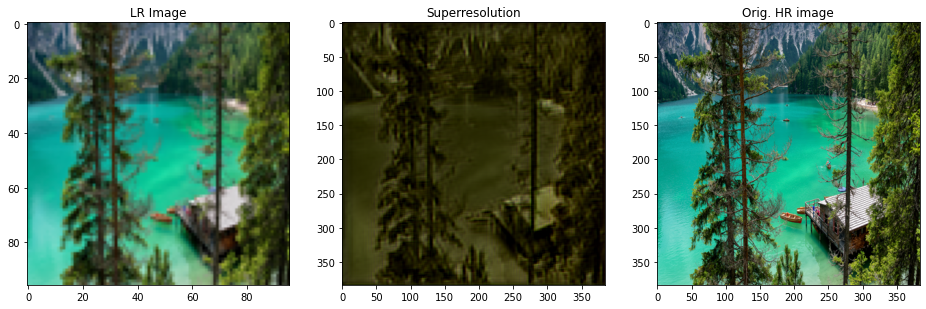

1/1 [==============================] - 1s 610ms/step


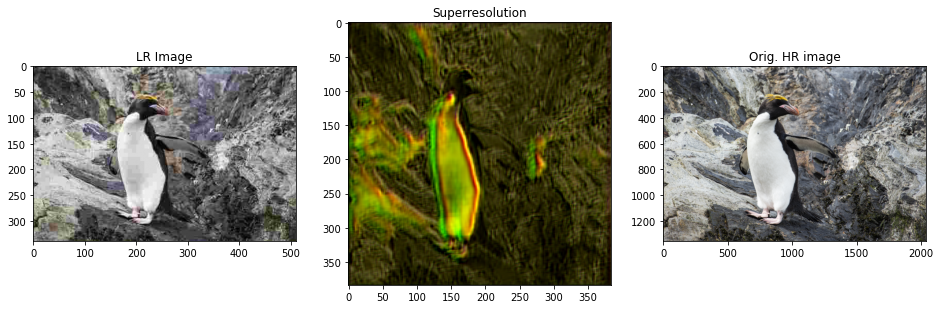

In [79]:
#Test - perform super resolution using saved generator model
from keras.models import load_model
from numpy.random import randint

generator = load_model('/content/gen_e_5.h5', compile=False)


[X1, X2] = [lr_test, hr_test]
# select random example
ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]

# generate image from source
gen_image = generator.predict(src_image)


# plot all three images

plt.figure(figsize=(16, 16))
plt.subplot(231)
plt.title('LR Image')
plt.imshow(src_image[0,:,:,:])
plt.subplot(232)
plt.title('Superresolution')
plt.imshow(gen_image[0,:,:,:])
plt.subplot(233)
plt.title('Orig. HR image')
plt.imshow(tar_image[0,:,:,:])

plt.show()


################################################
sreeni_lr = cv2.imread("/content/0801.jpg")
sreeni_hr = cv2.imread("/content/0801.png")

#Change images from BGR to RGB for plotting. 
#Remember that we used cv2 to load images which loads as BGR.
sreeni_lr = cv2.cvtColor(sreeni_lr, cv2.COLOR_BGR2RGB)
sreeni_hr = cv2.cvtColor(sreeni_hr, cv2.COLOR_BGR2RGB)

sreeni_lr = sreeni_lr / 255.
sreeni_hr = sreeni_hr / 255.

sreeni_lr = np.expand_dims(sreeni_lr, axis=0)
sreeni_hr = np.expand_dims(sreeni_hr, axis=0)

generated_sreeni_hr = generator.predict(sreeni_lr)

# plot all three images
plt.figure(figsize=(16, 16))
plt.subplot(231)
plt.title('LR Image')
plt.imshow(sreeni_lr[0,:,:,:])
plt.subplot(232)
plt.title('Superresolution')
plt.imshow(generated_sreeni_hr[0,:,:,:])
plt.subplot(233)
plt.title('Orig. HR image')
plt.imshow(sreeni_hr[0,:,:,:])

plt.show()